
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Machine Learning based uncertainty models

## Subsurface Property Prediction with Neural Networks

### Eduardo Maldonado Cruz, Graduate Research Assistant, The University of Texas at Austin

#### [Twitter](https://twitter.com/emaldonadocruz) | [GitHub](https://github.com/emaldonadocruz) | [LinkedIn](https://www.linkedin.com/in/eduardo-maldonado-8386a898/)

### Michael Pyrcz, Associate Professor, The University of Texas at Austin 

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

## Executive summary

Deep learning models focus on **prediction accuracy and minimizing prediction error**. Yet, for spatial models, **accurate predictions along with accurate and precise uncertainty models are critical.** 

Due to limited data veracity, data sparsity, and feature heterogeneity in the spatial setting, uncertainty is significant; therefore, **predicting a single estimate must be replaced with a prediction of the uncertainty distribution**.

**We propose a novel and easy to use objective function to summarize uncertainty model performance**.
The proposed function tunes deep learning models for optimum uncertainty accuracy and precision.

## Objective

Tune deep learning models for maximum **goodness**, **accuracy** and **precision**.

## Introduction

Deep learning models focus on prediction accuracy and minimizing prediction error. Yet, for spatial models, accurate predictions along with accurate and precise uncertainty models are critical. Prediction of the entire uncertainty model is accomplished robustly with Bayesian Neural Networks but with high computational cost(MacKay, 1991; Hinton and Van Camp 1993). Leading to the development of stochastic regularization techniques, one of the most popular is dropout (Hinton et al., 2012; Srivastava et al., 2014, Gal, 2016, Gal and Ghahramani., 2016, Kendall and Gal, 2017, Osband et al., 2016) that can be interpreted as a Bayesian approximation with greater computationally efficiency. 

Dropout is a technique that addresses overfitting in neural networks and provides an approach to improve prediction accuracy by ensemble learning. Dropout refers to randomly removing or reducing (also known as regularizing) network weights, removing or weakening the connections between the nodes in the neural network to introduce prediction model stochasticity during model training (Dahl, 2013; Srivastava, 2014; Hara, 2016). 

Ensemble predictions benefit from reduced model variance and improved prediction model generalization. The proposed method uses the machine learning dropout hyperparameter to calculate accurate and precise uncertainty models of response features. This objective function is based on the goodness metric proposed by Deutsch (1996).

The goodness of the uncertainty model (Maldonado and Pyrcz, 2021)

\begin{equation}
\mathrm{f}\left(x\right)=\frac{1}{2}\left[\frac{1}{n}\sum_{i=1}^{n}\left|y\left(\mathbf{u}_{\mathrm{i}}\right)-\hat{y}\left(\mathbf{u}_{\mathrm{i}}\right)\right|\right]+\frac{1}{2}\left[\int_{0}^{1}\left[3a\left(p\right)-2\right]\left[\overline{\xi\left(p\right)}-p\right]dp\right]
\label{eq:Goodness} \tag{1}
\end{equation}

where the first term is the typical mean absolute error (MAE) in testing between $𝑦_𝑖 (𝐮_𝐢 )$ training response feature values and $𝑦_𝑖 (𝐮_𝐢 )$ estimates over n withheld testing data, and the second term is a measure of goodness.

Where $\xi(𝐮_𝑖;𝑝)$ is the indicator function at each point $𝐮_𝑖, 𝑖=1,…,𝑛,$ evaluated over a range of symmetric 𝑝-probability intervals:

\begin{equation}
\xi\left(\mathbf{u}_{\mathrm{i}};p\right)=\begin{cases}
1, & F_{y}\left(\mathbf{u}_{\mathrm{i}};y\left(\mathbf{u}_{\mathrm{i}}\right)\right)\in\left(p_{low},p_{upp}\right]\\
0, & \mathrm{Otherwise}
\end{cases}
\label{eq:IndicatorFunc} \tag{2}
\end{equation}

Next, we use $\ref{eq:Goodness}$ as the objective function to tune a very simple uncertainty model.


## Library importing

First we must import some libraries to train a deep learning model.


In [1]:
# Set verbosity
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Libraries for data analysis and array manipulation
import pandas as pd
import numpy as np

# Libraries for plotting
import matplotlib.pyplot as plt
from matplotlib import colors

# Import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Lambda
from tensorflow.keras import backend as K

#Librabry with useful analysis statistics
from scipy import stats
from scipy import integrate
import random


# Preprocessing and train-test split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# library for hyperparameter search
import optuna

#To import, save and load jobs
import joblib

In [2]:
tf.random.set_seed(0)
np.random.RandomState(38)
np.random.seed(38)

In [3]:
!pip install UTuning

In [4]:
#import sys
#sys.path.insert(0, r'C:\Users\em42363\OneDrive\PhD\UTuning')

from UTuning import scorer, plots

In [5]:
## Plots
import matplotlib.pyplot as plt
import numpy as np
import random

import matplotlib.tri as tri
from scipy.ndimage import gaussian_filter

#import matplotlib
#matplotlib.rcParams['text.usetex'] = True


def error_line(Prediction, Truth, Sigma, Frac=1):
    '''Simple function to draw an error line plot. It takes three arrays of the same length 

    Parameters
    ----------

    Prediction : float array
        The predicted value array (Prediction)
    Truth : float array
        The truth value array (Truth) 
    Sigma : float array
        The standard deviation array (Sigma)
    Frac : float 
        Frac is the fraction of points to display randomly

    Returns
    -------
    Scatter plot
    '''
    yline = [min(Prediction.min(), Truth.min()),
             max(Prediction.max(), Truth.max())]
    xline = [min(Prediction.min(), Truth.min()),
             max(Prediction.max(), Truth.max())]

    fig, ax = plt.subplots(figsize=(10, 6))
    # To display randomly less points [Remove , Keep] in fraction
    mask = np.random.choice([False, True], len(Prediction), p=[(1-Frac), (Frac)])
    ax.errorbar(Prediction[mask], Truth[mask], xerr=Sigma[mask],
                fmt='k.',
                ecolor='k')
    ax.plot(xline, yline, '-k')
    ax.set_xlabel('Predicted value, $\hat{y}$')
    ax.set_ylabel('True value, $y$ ')
    plt.show()

def error_accuracy_plot(percentile,IF_array,Prediction_array,Truth,Sigma):
    '''Simple function to draw an error line plot and its corresponding accuracy plot. 

    Parameters
    ----------

    Prediction : float array
        The predicted value array (Prediction)
    Truth : float array
        The truth value array (Truth) 
    Sigma : float array
        The standard deviation array (Sigma)
    Frac : float 
        Frac is the fraction of points to display randomly

    Returns
    -------
    Scatter plot
    '''
    avgIndFunc = np.mean(IF_array, axis=0)
    
    L = 10
    mean = np.empty((L, len(percentile)))

    for p_interv in range(len(percentile)):
        for l in np.arange(0, L):
            samples = random.choices(IF_array[:, p_interv],
                                     k=IF_array.shape[0])
            mean[l, p_interv] = np.mean(samples)
            
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    
    if len(Prediction_array.shape)>1:
        xline = [0,max(np.mean(Prediction_array,axis=1).max(),Truth.max())+max(np.mean(Prediction_array,axis=1).max(),Truth.max())*0.1]#
        yline = [0,xline[1]]#
    
        ax1.errorbar(np.mean(Prediction_array,axis=1), Truth, xerr=Sigma, 
                     fmt='k.',
                     ecolor='k')
    else:
        xline = [0,max(Prediction_array.max(),Truth.max())+max(Prediction_array.max(),Truth.max())*0.1]#
        yline = [0,xline[1]]#
    
        ax1.errorbar(Prediction_array, Truth, xerr=Sigma, 
                     fmt='k.',
                     ecolor='k')
    ax1.plot(xline, yline, '-k')
    ax1.set_xlabel('Predicted value, $\hat{y}$')
    ax1.set_ylabel('True value, $y$ ')

    ax2.plot(percentile, avgIndFunc,'-ok',markersize=5)
    ax2.plot(percentile,np.round(avgIndFunc+np.std(mean, axis=0), 3),'--k')
    ax2.plot(percentile,np.round(avgIndFunc-np.std(mean, axis=0), 3),'--k')
    ax2.plot([0, 1],[0, 1],'-k')
    ax2.set_ylabel(r"$\overline{\xi (p)}$")
    ax2.set_xlabel('Probability interval $p$')
    ax2.set_ylim(0,1)
    ax2.set_xlim(0,1)

    ax2.plot(percentile, avgIndFunc,'-ok',markersize=5)
    

def surface(x, y, z, levels, labels):
    
    fig, (ax1) = plt.subplots(nrows=1,figsize=(12,6))
    
    npoints=x.shape[0]
    smooth=1
    
    # Create grid values first.
    xi = np.linspace(x.min(), x.max(), npoints)
    yi = np.linspace(y.min(), y.max(), npoints)
    
    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    zi = gaussian_filter(zi, smooth)
    
    levels = levels
    
    ax1.contour(xi, yi, zi, levels=levels, linewidths=0.1, colors='k')
    
    cntr1 = ax1.contourf(xi, yi, zi, levels=levels, cmap="inferno",alpha=0.95)
    
    cbar = plt.colorbar(cntr1, ax=ax1)
    cbar.set_label(labels['z'], rotation=270,labelpad=30)
    
    ax1.set(xlim=(x.min(), x.max()),ylim=(y.min(), y.max()))

    ax1.scatter(x,y,s=7,color='white')
    ax1.set_xlabel(labels['x'])
    ax1.set_ylabel(labels['y'])
    
    
    plt.show()


In [6]:
## Scorer
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate

class scorer:
    '''
    Scorer class, a class to represent the accuracy, precision and goodness
    score from an uncertainty model.
    
    Attributes
    ----------
    Accuracy : float
    Precision : float
    Goodness : float
    Overall uncertainty : float
    Indicator Function : float array
    '''
    def __init__(self, Prediction, Truth, Sigma):
        
        n_quantiles = 11
        self.perc = np.linspace(0.0, 1.01, n_quantiles)
        # self.A_array=np.zeros(Prediction.shape[0])
        # self.P_array=np.zeros(Prediction.shape[0])
        # self.G_array=np.zeros(Prediction.shape[0])
        #self.U_array=np.zeros(Prediction.shape[0])

        self.IF_array=np.zeros((Prediction.shape[0],n_quantiles))
        
        if len(Prediction.shape)>1:
            for i in range(Prediction.shape[0]):
                IF = APG_calc(Truth[i], Prediction[i,:], Sigma[i],n_quantiles)
                #self.U_array[i]=U
                # self.A_array[i]=A
                # self.P_array[i]=P
                # self.G_array[i]=G
                self.IF_array[i,:] = IF
        else:
            Pred_array = np.zeros((Sigma.shape[0],100))
            for i in range(Prediction.shape[0]):
                Pred_array[i,:] = np.random.normal(loc=Prediction[i],scale=Sigma[i],size=100)
                IF = APG_calc(Truth[i], Pred_array[i,:], Sigma[i],n_quantiles)
                #self.U_array[i]=U
                # self.A_array[i]=A
                # self.P_array[i]=P
                # self.G_array[i]=G
                self.IF_array[i,:] = IF
        
        self.avgIndFunc = np.mean(self.IF_array, axis=0)
        
        self.a = np.zeros(len(self.avgIndFunc))
        for i in range(len(self.avgIndFunc)):
            if self.avgIndFunc[i] > self.perc[i] or self.avgIndFunc[i] == self.perc[i]:
                self.a[i] = 1
            else:
                self.a[i] = 0
        
    def Accuracy(self):
        Accuracy = integrate.simps(self.a, self.perc)
        return Accuracy
        #return print('Accuracy = {0:2.2f}'.format(np.mean(self.A_array)))
    
    def Precision(self):
        Prec = self.a*(self.avgIndFunc-self.perc)
        Precision = 1-2*integrate.simps(Prec, self.perc)
        return Precision
        #return print('Precision = {0:2.2f}'.format(np.mean(self.P_array)))
    
    def Goodness(self):
        Sum = (3*self.a-2)*(self.avgIndFunc-self.perc)
        Goodness = 1-integrate.simps(Sum, self.perc)
        return Goodness
        #return print('Goodness = {0:2.2f}'.format(np.mean(self.G_array)))

    def Overall_uncertainty(self,Sigma):
        return Sigma.mean()
        #return print('Overall uncertainty = {0:2.2f}'.format(np.mean(self.G_array)))
    
    def IndicatorFunction(self):
        return self.IF_array

def APG_calc(Truth, Pred, Sigma,n_quantiles):

    mask = np.random.choice([False, True],
                            len(Pred),
                            p=[0, 1]) # To display randomly less points [Remove , Keep] in fraction

    Pred=Pred[mask]
    
    perc = np.linspace(0.0, 1.01, n_quantiles)

    F = np.zeros(Pred.shape[0])
    Indicator_func = np.zeros((Pred.shape[0], perc.shape[0]))

    # range of symmetric p-probability intervals
    plow = (1 - perc) / 2
    pupp = (1 + perc) / 2
    
    for i in range(len(Pred)):
        F[i] = stats.norm.cdf(Truth,
                          loc=Pred[i],
                          scale=Sigma)
        for proba_low, proba_upp in zip(plow, pupp):
            for k in range(len(plow)):
                if plow[k] < F[i] <= pupp[k]:
                    Indicator_func[i, k] = 1
                else:
                    Indicator_func[i, k] = 0

    avgIndFunc = np.mean(Indicator_func, axis=0)

    return avgIndFunc


In [7]:
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Functions

First lets define some useful functions that will be later used for plotting and case evaluation

In [8]:
# Custom functions
def get_dataframe(mc_predictions, y_s, X_s):
    '''
    This function takes the sampled distribution along with the testing data and obtains
    the mean, variance and standard deviation, from this function we get the dataframe
    to construct the accuracy plot.
    '''
    
    Mean = np.zeros((mc_predictions.shape[1]))
    Var = np.zeros((mc_predictions.shape[1]))
    STD = np.zeros((mc_predictions.shape[1]))
    
    for i in range(mc_predictions.shape[1]):
        Mean[i] = np.average(mc_predictions[:, i])
        Var[i] = np.var(mc_predictions[:, i])
        STD[i] = np.std(mc_predictions[:, i])

    mask = np.random.choice([False, True], len(Mean), p=[0.5, 0.5])
    
    df = pd.DataFrame()
    
    df['Pred'] = Mean[mask]
    df['Truth'] = y_s[mask]
    df['Var'] = Var[mask]
    df['Sigma'] = np.sqrt(Var[mask])
    
    return df

def get_GAP(MeanVal, Sigma, Truth, n_quantiles):
    '''
    This function takes the dataframe and calculates the indicator function and the average
    we then use this information to estimate the accuracy, goodness and precision of the model.
    '''
    perc = np.linspace(0.0, 1.00, n_quantiles)
    F = np.zeros(MeanVal.shape[0])
    Indicator_func = np.zeros((MeanVal.shape[0], perc.shape[0]))

    # range of symmetric p-probability intervals
    plow = (1 - perc) / 2
    pupp = (1 + perc) / 2
        
    for i in range(len(MeanVal)):
        F[i] = stats.norm.cdf(Truth[i],
                              loc=MeanVal[i],
                              scale=Sigma[i])
        for proba_low, proba_upp in zip(plow, pupp):
            for k in range(len(plow)):
                if plow[k] < F[i] <= pupp[k]:
                    Indicator_func[i, k] = 1
                else:
                    Indicator_func[i, k] = 0

    avgIndFunc = np.mean(Indicator_func, axis=0)
    
    a = np.zeros(len(avgIndFunc))
    for i in range(len(avgIndFunc)):
        if avgIndFunc[i] > perc[i] or avgIndFunc[i] == perc[i]:
            a[i] = 1
        else:
            a[i] = 0
    print(f'Overall uncertainty = {Sigma.mean():.6f}')
    U = Sigma.mean()
    
    ##% Goodness, Precision and Accuracy
    

    Accuracy = integrate.simps(a, perc)

    Prec = a*(avgIndFunc-perc)
    Precision = 1-2*integrate.simps(Prec, perc)

    Sum = (3*a-2)*(avgIndFunc-perc)
    Goodness = 1-integrate.simps(Sum, perc)

    return Goodness, Precision, Accuracy, U, Indicator_func,perc

def error_line(Mean,Truth,STD,r):
    '''
    Simple function to draw an error line plot. It takes the mean predicted value,
    the truth value and the standard deviation.
    '''
    
    xline = [0,1]#
    yline = [0,1]#
    plt.figure(figsize=(10, 6))
    mask = np.random.choice([False, True], len(Mean), p=[0.5, 0.5])
    plt.errorbar(Mean[mask], Truth[mask], xerr=STD[mask], 
                 fmt='k.', ecolor='k',label="Pearson's r = {0:2.2f}".format(r))
    plt.legend()
    plt.plot(xline, yline, '-k')
    
    plt.xlabel('Predicted value, $\hat{y}$ [bl]')
    plt.ylabel('True value, $y$ [bl]')

    plt.show()
    
def accuracy_plot(Indicator_func,perc):
    '''
    This function takes the indicator function and percentiles to draw the accuracy plot.
    '''
    
    L = 100  
    mean = np.empty((L, len(perc)))
    std = np.empty_like(mean)
    avgIndFunc = np.mean(Indicator_func, axis=0)
    for p_interv in range(len(perc)):
        for l in np.arange(0, L):
            samples = random.choices(Indicator_func[:, p_interv],
                                     k=Indicator_func.shape[0])
            mean[l, p_interv] = np.mean(samples)

    plt.figure(figsize=(10, 6))
    plt.plot(perc, avgIndFunc,'-ok',markersize=5)
    plt.plot(perc,np.round(avgIndFunc+np.std(mean, axis=0), 3),'--k')
    plt.plot(perc,np.round(avgIndFunc-np.std(mean, axis=0), 3),'--k')
    plt.plot([0, 1],[0, 1],'-k')
    plt.ylabel(r"$\overline{\xi (p)}$")
    plt.xlabel('Probability interval $p$')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()

def histogram(mc_predictions):
    '''
    From the Monte Carlo predictions we draw a random point and construct the
    histogram of predictions from the model
    '''
    
    Avg = []
    rand=np.random.randint(0,mc_predictions.shape[1])
    for i in range(mc_predictions.shape[0]):
        Avg.append(np.average(mc_predictions[i,rand]))

    Std = np.std(Avg)

    # Histograms
    n_bins = 20
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    N, bins, patches = axs.hist(Avg,
                                bins=n_bins,
                                label='$\sigma$ = %2.5f' % Std)
    #axs.set_title('Root Mean squared error in barrels for each cell');
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.binary(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.legend()
    plt.ylabel('Number of cases')
    plt.xlabel('Normalized production value')
    
def histogram_fixed(Prediction,rand):
    '''
    From the Monte Carlo predictions we draw a random point and construct the
    histogram of predictions from the model
    '''
    
    Pred_array = np.zeros(100)
    Pred_array = np.random.normal(loc=np.mean(Prediction[:,rand]),scale=np.std(Prediction[:,rand]),size=500)

    # Histograms
    n_bins = 15
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    N, bins, patches = axs.hist(Pred_array,
                                bins='auto',
                                color = 'black',
                                label='$\sigma$ = %2.5f' % np.std(Prediction[:,rand]),
                                rwidth = 0.85,
                                alpha =0.85)
    plt.legend()
    plt.ylabel('Number of cases')
    plt.xlabel('Normalized production value')
    
def plot_loss(history):
    '''
    Simple function to plot the loss for the training and testing data
    '''
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Testing loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss ')
    plt.legend()
    plt.grid(True)    

def objective(trial):
    '''
    We use this function to define the search space for the hyperparameter search.
    This function creates, train and evaluates the model.
    '''

    dropout = trial.suggest_discrete_uniform('Dropout', 0.05, 0.95, 0.01)
    lr = float(trial.suggest_discrete_uniform('learn_rate', 0.001, .03, 0.001))
    
    model = create_model(dropout)
    
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(loss='mae',
                  optimizer=opt,
                  metrics='mse')

    model.fit(
        X_train,
        y_train,
        shuffle=True,
        batch_size=16,
        epochs=100,
        verbose=False,
    )
    score = model.evaluate(X_test, y_test, verbose=0)

    mc_predictions = evaluate_cases(model, X_test, 8, y_test,100)
    #df = get_dataframe(mc_predictions, y_test, X_test)
    #df.to_csv('ModelPredictions.csv')
    
    Sigma = np.std(mc_predictions , axis = 0)
    Pred_array = mc_predictions
    Pred = np.mean(mc_predictions , axis = 0)    
    A, P, G = model_eval(y_test,mc_predictions,Sigma,np.mean(mc_predictions,axis=0))
    
    Score = 0.5*score[0]+0.5*(1-G)

    return Score

def APG_calc(Truth, Pred, Sigma,n_quantiles):

    mask = np.random.choice([False, True],
                            len(Pred),
                            p=[0.0, 1]) # To display randomly less points [Remove , Keep] in fraction

    Pred=Pred[mask]
    perc = np.linspace(0.0, 1.00, n_quantiles)

    F = np.zeros(Pred.shape[0])
    Indicator_func = np.zeros((Pred.shape[0], perc.shape[0]))

    # range of symmetric p-probability intervals
    plow = (1 - perc) / 2
    pupp = (1 + perc) / 2
    
    for i in range(len(Pred)):
        F[i] = stats.norm.cdf(Truth,
                          loc=Pred[i],
                          scale=Sigma)
        for proba_low, proba_upp in zip(plow, pupp):
            for k in range(len(plow)):
                if plow[k] < F[i] <= pupp[k]:
                    Indicator_func[i, k] = 1
                else:
                    Indicator_func[i, k] = 0

    avgIndFunc = np.mean(Indicator_func, axis=0)
    
    return avgIndFunc

def model_eval(y_test,Pred_array,Sigma,Pred):
    
    n_quantiles=11
    perc = np.linspace(0.0, 1.00, n_quantiles)
    
    Truth = y_test

    IF_array=np.zeros((Pred_array.shape[0],n_quantiles))

    for i in range(Pred_array.shape[0]):
        IF=APG_calc(Truth[i], Pred_array[:,i], Sigma[i],n_quantiles)
        IF_array[i,:] = IF
        
    avgIndFunc = np.mean(IF_array, axis=0)

    a = np.zeros(len(avgIndFunc))
    for i in range(len(avgIndFunc)):
        if avgIndFunc[i] > perc[i] or avgIndFunc[i] == perc[i]:
            a[i] = 1
        else:
            a[i] = 0

    Accuracy = integrate.simps(a, perc)

    Prec = a*(avgIndFunc-perc)
    
    Precision = 1-2*integrate.simps(Prec, perc)

    Sum = (3*a-2)*(avgIndFunc-perc)

    Goodness = 1-integrate.simps(Sum, perc)
    
    print('Accuracy = {0:1.2f}'.format(Accuracy))
    print('Precision = {0:1.2f}'.format(Precision))
    print('Goodness = {0:1.2f}'.format(Goodness))

    L = 100
    mean = np.empty((L, len(perc)))

    for p_interv in range(len(perc)):
        for l in np.arange(0, L):
            samples = random.choices(IF_array[:, p_interv],
                                     k=IF_array.shape[0])
            mean[l, p_interv] = np.mean(samples)

    mask = np.random.choice([False, True],
                            len(Pred),
                            p=[0.95, 0.05]) # To display randomly less points [Remove , Keep] in fraction

    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    xline = [0,max(Pred.max(),Truth.max())+max(Pred.max(),Truth.max())*0.1]#
    yline = [0,xline[1]]#
    ax1.errorbar(Pred[mask], Truth[mask], xerr=Sigma[mask], 
                 fmt='k.',
                 ecolor='k')
    ax1.plot(xline, yline, '-k')
    ax1.set_xlabel('Predicted value, $\hat{y}$')
    ax1.set_ylabel('True value, $y$ ')
    ax2.plot(perc, avgIndFunc,'-ok',markersize=5)
    ax2.plot(perc,np.round(avgIndFunc+np.std(mean, axis=0), 3),'--k')
    ax2.plot(perc,np.round(avgIndFunc-np.std(mean, axis=0), 3),'--k')
    ax2.plot([0, 1],[0, 1],'-k')
    ax2.set_ylabel(r"$\overline{\xi (p)}$")
    ax2.set_xlabel('Probability interval $p$')
    ax2.set_ylim(0,1)
    ax2.set_xlim(0,1)
    ax2.plot(perc, avgIndFunc,'-ok',markersize=5)
    plt.show()
    
    return Accuracy,Precision,Goodness

def evaluate_cases(model, X_s, batch_size,y_s,n_samples):
    '''
    This function takes the model, the testing data, a batch size and an integer representing
    the number of samples that the model will produce.
    '''
    #Take n_samples to draw a distribution
    mc_predictions = np.zeros((n_samples, y_s.shape[0]))
    for i in range(n_samples):
        y_p = model.predict(X_s, verbose=1, batch_size=batch_size)
        mc_predictions[i] = (y_p[:,0])
    
    return mc_predictions



## Dataset exploration

For this notebook example we have a problem that consists on predicting **Production** from **Porosity**, **Permeability**, **Brittleness** and **TOC**. We have selected this problem because we are primarily interested in capturing the uncertainty related to predictions of Production based on existing data. 

This problem can be expanded to any prediction problem.

First lets import the dataset:

In [9]:
df=pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv')

Some information about our dataset, we have 5 columns including Porosity, Permeability, Acoustic impedance, Density and Facies.

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WellIndex,1000.0,500.500000,288.819436,1.000000,250.75000,500.50000,750.250000,1000.00000
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


Now we separate or data between predictor features and response features.
We use Porosity, Permeability, Brittleness and Total Oil Content values to predict production

In [11]:
y = df['Production'].values
x = df[['Por', 'LogPerm', 'Brittle', 'TOC']].values

## Data normalization and split train-test

To speed up things, we can choose to randomly remove points of the dataset using the following code:

```python
mask = np.random.choice([False, True], len(x), p=[0.5, .5])  #Remove, Keep
```

In [12]:
mask = np.random.choice([False, True], len(x), p=[0, 1])  #Remove, Keep
x=x[mask,:]
y=y[mask]

Then we perform a min max normalization over the reponse features

In [13]:
ymin=y.min()
ymax=y.max()
y = (y-ymin)/(ymax-ymin)

And apply standarization over the predictor features

In [14]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

Next, we split our data in training-testing.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33,random_state=20)

## Neural network model, deterministic

Next we define the neural network model under the class create_model. This is a classic deterministic model. We generate the exact same outcomes under a given set of initial conditions.


In [16]:
class create_model(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.input_layer = keras.layers.Flatten(input_shape=[x.shape[1]])
        self.hidden1 = keras.layers.Dense(24, activation='relu')
        self.hidden2 = keras.layers.Dense(24, activation='relu')
        self.hidden3 = keras.layers.Dense(24, activation='relu')
        self.output_layer = keras.layers.Dense(1)

    def call(self, input, training=True):
        input_layer = self.input_layer(input)
        hidden1 = self.hidden1(input_layer)
        hidden2 = self.hidden2(hidden1)
        output_layer = self.output_layer(hidden2)
        return output_layer

The following information is used to save or load the model weights.

In [17]:
path = ""
name = "Production_predict"
weights_path = path + name + '.h5'

### Training

Before training we must instantiate the model, lets use Mean Absolute Error as loss function to guide our model for better results.

In [18]:
model = create_model()

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mae',
              optimizer=opt,
              metrics='mse')

And fit our model

In [19]:
history=model.fit(
    X_train,
    y_train,
    shuffle=True,
    batch_size=16,
    epochs=300,
    verbose=True,
    validation_data=(X_test,y_test)
)

Epoch 1/300
42/42 [==============================] - 0s 4ms/step - loss: 0.0814 - mse: 0.0144 - val_loss: 0.0416 - val_mse: 0.0034
Epoch 2/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0321 - mse: 0.0020 - val_loss: 0.0348 - val_mse: 0.0023
Epoch 3/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0275 - mse: 0.0015 - val_loss: 0.0276 - val_mse: 0.0017
Epoch 4/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0192 - mse: 7.2834e-04 - val_loss: 0.0239 - val_mse: 0.0015
Epoch 5/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0217 - mse: 9.6677e-04 - val_loss: 0.0188 - val_mse: 0.0011
Epoch 6/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0197 - mse: 8.8205e-04 - val_loss: 0.0237 - val_mse: 0.0013
Epoch 7/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0216 - mse: 9.7121e-04 - val_loss: 0.0174 - val_mse: 0.0010
Epoch 8/300
42/42 [==============================] - 0s 1ms/step - 

Epoch 60/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0086 - mse: 1.5963e-04 - val_loss: 0.0094 - val_mse: 2.2123e-04
Epoch 61/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0063 - mse: 8.4366e-05 - val_loss: 0.0077 - val_mse: 2.2877e-04
Epoch 62/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0077 - mse: 1.3357e-04 - val_loss: 0.0066 - val_mse: 1.8032e-04
Epoch 63/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0066 - mse: 9.2224e-05 - val_loss: 0.0073 - val_mse: 2.0599e-04
Epoch 64/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0062 - mse: 8.2988e-05 - val_loss: 0.0082 - val_mse: 1.9170e-04
Epoch 65/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0077 - mse: 1.2470e-04 - val_loss: 0.0117 - val_mse: 3.3148e-04
Epoch 66/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0077 - mse: 1.2306e-04 - val_loss: 0.0099 - val_mse: 2.6347e-04
Epoch 67/300
42/42 [

42/42 [==============================] - 0s 1ms/step - loss: 0.0064 - mse: 9.1852e-05 - val_loss: 0.0080 - val_mse: 2.3247e-04
Epoch 119/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0076 - mse: 1.2927e-04 - val_loss: 0.0061 - val_mse: 1.2387e-04
Epoch 120/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0060 - mse: 6.8821e-05 - val_loss: 0.0080 - val_mse: 1.8310e-04
Epoch 121/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0067 - mse: 9.2615e-05 - val_loss: 0.0068 - val_mse: 1.6435e-04
Epoch 122/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0055 - mse: 5.2821e-05 - val_loss: 0.0070 - val_mse: 1.1260e-04
Epoch 123/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0070 - mse: 9.1530e-05 - val_loss: 0.0072 - val_mse: 2.3776e-04
Epoch 124/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0061 - mse: 8.6660e-05 - val_loss: 0.0061 - val_mse: 1.7995e-04
Epoch 125/300
42/42 [======

42/42 [==============================] - 0s 1ms/step - loss: 0.0060 - mse: 6.8270e-05 - val_loss: 0.0063 - val_mse: 1.4447e-04
Epoch 177/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0061 - mse: 8.5488e-05 - val_loss: 0.0068 - val_mse: 1.1309e-04
Epoch 178/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0071 - mse: 1.0531e-04 - val_loss: 0.0084 - val_mse: 1.8008e-04
Epoch 179/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0057 - mse: 6.2985e-05 - val_loss: 0.0045 - val_mse: 5.8746e-05
Epoch 180/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0054 - mse: 5.6227e-05 - val_loss: 0.0061 - val_mse: 1.0869e-04
Epoch 181/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0058 - mse: 7.0476e-05 - val_loss: 0.0086 - val_mse: 1.6577e-04
Epoch 182/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0064 - mse: 8.1801e-05 - val_loss: 0.0048 - val_mse: 6.9696e-05
Epoch 183/300
42/42 [======

42/42 [==============================] - 0s 1ms/step - loss: 0.0059 - mse: 7.3415e-05 - val_loss: 0.0057 - val_mse: 1.2236e-04
Epoch 235/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0066 - mse: 8.6901e-05 - val_loss: 0.0046 - val_mse: 1.0557e-04
Epoch 236/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0047 - mse: 4.1018e-05 - val_loss: 0.0042 - val_mse: 7.6049e-05
Epoch 237/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0051 - mse: 4.9177e-05 - val_loss: 0.0064 - val_mse: 1.4833e-04
Epoch 238/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0053 - mse: 5.7200e-05 - val_loss: 0.0067 - val_mse: 2.1210e-04
Epoch 239/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0064 - mse: 8.0688e-05 - val_loss: 0.0067 - val_mse: 1.3086e-04
Epoch 240/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0057 - mse: 6.1370e-05 - val_loss: 0.0051 - val_mse: 9.5057e-05
Epoch 241/300
42/42 [======

42/42 [==============================] - 0s 1ms/step - loss: 0.0057 - mse: 6.6741e-05 - val_loss: 0.0113 - val_mse: 2.2855e-04
Epoch 293/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0093 - mse: 1.6509e-04 - val_loss: 0.0056 - val_mse: 1.0089e-04
Epoch 294/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0052 - mse: 4.9412e-05 - val_loss: 0.0054 - val_mse: 6.5134e-05
Epoch 295/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0050 - mse: 5.0847e-05 - val_loss: 0.0082 - val_mse: 1.7439e-04
Epoch 296/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0050 - mse: 4.6717e-05 - val_loss: 0.0052 - val_mse: 8.8916e-05
Epoch 297/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0050 - mse: 4.7274e-05 - val_loss: 0.0060 - val_mse: 1.0869e-04
Epoch 298/300
42/42 [==============================] - 0s 1ms/step - loss: 0.0065 - mse: 8.1333e-05 - val_loss: 0.0073 - val_mse: 1.6940e-04
Epoch 299/300
42/42 [======

We plot the loss function to diagnostic the model and the dataset, from the plot we can identify

- A separation between the test and train loss function might indicate overfitting
- A large gap between the curves might indicate an unrepresentative train dataset


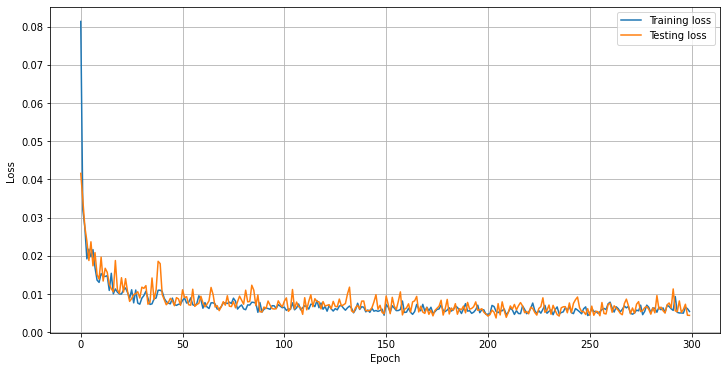

In [20]:
plot_loss(history)

Next we predict and compare our predictions with the observed occurrences. Now this model is very accurate and for every combination of predictor features we will have the exact same outcome.

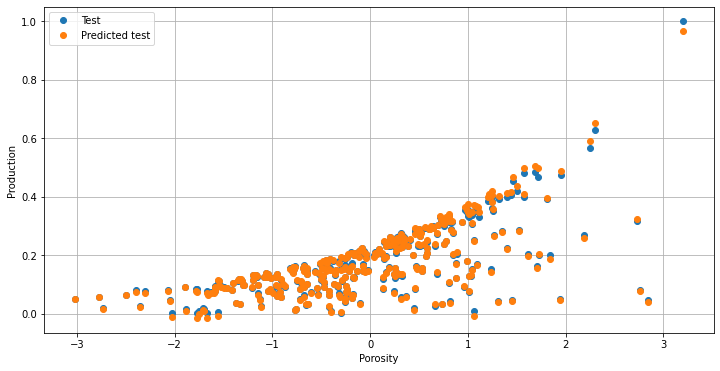

In [21]:
y_test_pred = model.predict(X_test)
plt.figure(figsize=(12,6))
plt.plot(X_test[:,0],y_test,'o',label='Test')
plt.plot(X_test[:,0],y_test_pred,'o',label='Predicted test')
plt.xlabel('Porosity')
plt.ylabel('Production')
plt.legend()
plt.grid(True)

The next thing we do is we test the goodness of the model. Lets evaluate the model 10 times to estimate the Goodness, Precision and Acurracy of the model. 

We could only do this once, because of the deterministic nature of the model, all 10 evaluations we will give the same result

In [22]:
mc_predictions = evaluate_cases(model, X_test, 8, y_test,10)
df = get_dataframe(mc_predictions, y_test, X_test)

42/42 [==============================] - 0s 585us/step


How does the cross plot for predicted versus true value look like?

What about the Pearson's product moment correlation coefficient?

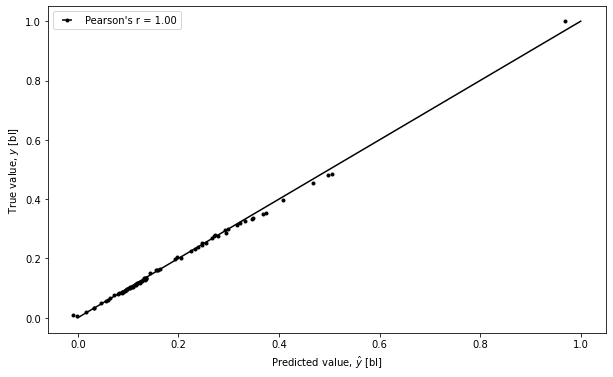

In [23]:
r= stats.pearsonr(df.Pred,df.Truth)
error_line(df.Pred,df.Truth,df.Sigma,r[0])

What is the Goodness, Precision and Accuracy of the model?

In [24]:
Sigma = np.sqrt(np.var(mc_predictions.T, axis=1))

score = scorer(mc_predictions.T, y_test, Sigma)

IF_array = score.IndicatorFunction()
n_quantiles = 11
perc = np.linspace(0.0, 1.00, n_quantiles)


C:\Users\em42363\Anaconda3\envs\new\lib\site-packages\scipy\stats\_distn_infrastructure.py:1987: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Very precise! But inaccurate

In [25]:
print('Accuracy = {0:2.2f}'.format(score.Accuracy()))
print('Precision = {0:2.2f}'.format(score.Precision()))
print('Goodness = {0:2.2f}'.format(score.Goodness()))

Accuracy = 0.03
Precision = 1.00
Goodness = -0.02


The precision is 1 and the goodness is 0!! The model is inaccurate and precise

How does the histogram of predictions for a random case look like? All 10 occurrences have the same result

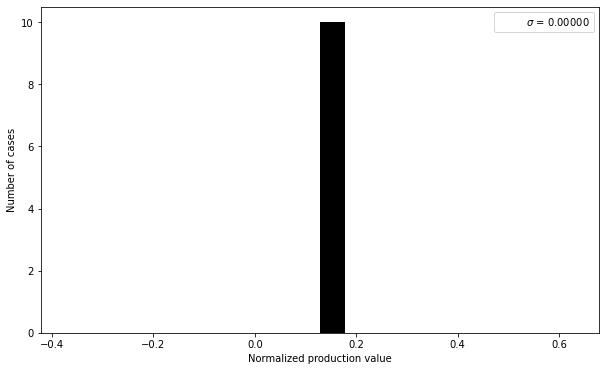

In [26]:
histogram(mc_predictions)

We can use the accuracy plot to diagnose our model. You can find more details on the use of the accuracy plots in the provided article.

How does the accuracy plot look like for a deterministic model?

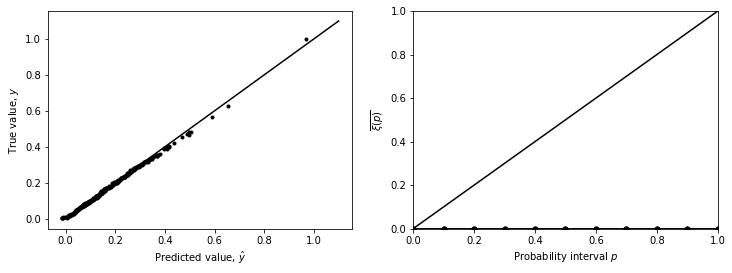

In [27]:
error_accuracy_plot(perc, IF_array, mc_predictions.T, y_test, Sigma)

Our model is **inaccurate and imprecise.**

## Neural network model, probabilistic

For this second model we use **dropout** to introduce randomness into our model

### Neural network model

Similarly as before, we define the model and include dropout layers in our deep learning model.

In [28]:
def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate)) # Fraction of the input units to drop

class create_model(keras.Model):
    def __init__(self,dropout, **kwargs):
        super().__init__(**kwargs)
        self.input_layer = keras.layers.Flatten(input_shape=[x.shape[1]])
        self.hidden1 = keras.layers.Dense(32, activation='relu')
        self.hidden2 = keras.layers.Dense(32, activation='relu')
        self.hidden3 = keras.layers.Dense(32, activation='relu')
        self.output_layer = keras.layers.Dense(1)
        self.dropout_layer = PermaDropout(rate=dropout)

    def call(self, input, training=True):
        input_layer = self.input_layer(input)
        input_layer = self.dropout_layer(input_layer)
        hidden1 = self.hidden1(input_layer)
        hidden1 = self.dropout_layer(hidden1, training=training)
        hidden2 = self.hidden2(hidden1)
        hidden2 = self.dropout_layer(hidden2, training=training)
        #hidden3 = self.hidden3(hidden2)
        #hidden3 = self.dropout_layer(hidden3, training=training)
        output_layer = self.output_layer(hidden2)
        return output_layer

### Training

We instantiate the model and define a dropout value that was previously optimized using the uncertainty model goodness metric

In [29]:
#model = create_model(0.0525)
model = create_model(0.06)
opt = keras.optimizers.Adam(learning_rate=0.016)

model.compile(loss='mae',
              optimizer=opt,
              metrics='mse')

In [30]:
history=model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=100,
    verbose=True,
    validation_data=(X_test,y_test)
)

Epoch 1/100
42/42 [==============================] - 1s 3ms/step - loss: 0.0813 - mse: 0.0138 - val_loss: 0.0475 - val_mse: 0.0058
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0385 - mse: 0.0033 - val_loss: 0.0410 - val_mse: 0.0047
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 0.0331 - mse: 0.0026 - val_loss: 0.0254 - val_mse: 0.0019
Epoch 4/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0273 - mse: 0.0019 - val_loss: 0.0276 - val_mse: 0.0024
Epoch 5/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0274 - mse: 0.0018 - val_loss: 0.0298 - val_mse: 0.0028
Epoch 6/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0300 - mse: 0.0029 - val_loss: 0.0279 - val_mse: 0.0025
Epoch 7/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0276 - mse: 0.0024 - val_loss: 0.0284 - val_mse: 0.0022
Epoch 8/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0302 - m

42/42 [==============================] - 0s 1ms/step - loss: 0.0248 - mse: 0.0017 - val_loss: 0.0248 - val_mse: 0.0019
Epoch 64/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0241 - mse: 0.0022 - val_loss: 0.0248 - val_mse: 0.0016
Epoch 65/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0270 - mse: 0.0021 - val_loss: 0.0287 - val_mse: 0.0025
Epoch 66/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0248 - mse: 0.0019 - val_loss: 0.0257 - val_mse: 0.0019
Epoch 67/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0252 - mse: 0.0018 - val_loss: 0.0221 - val_mse: 0.0017
Epoch 68/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0245 - mse: 0.0018 - val_loss: 0.0251 - val_mse: 0.0018
Epoch 69/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0307 - mse: 0.0029 - val_loss: 0.0275 - val_mse: 0.0021
Epoch 70/100
42/42 [==============================] - 0s 1ms/step - loss: 0.0240 - mse: 0

Next we plot the loss for the training and testing dataset. We observe no overfitting in our model. We had to increase the number of epochs because of the regularization parameter

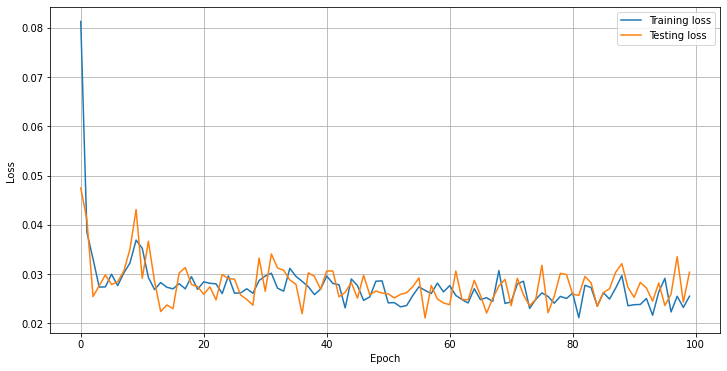

In [31]:
plot_loss(history)

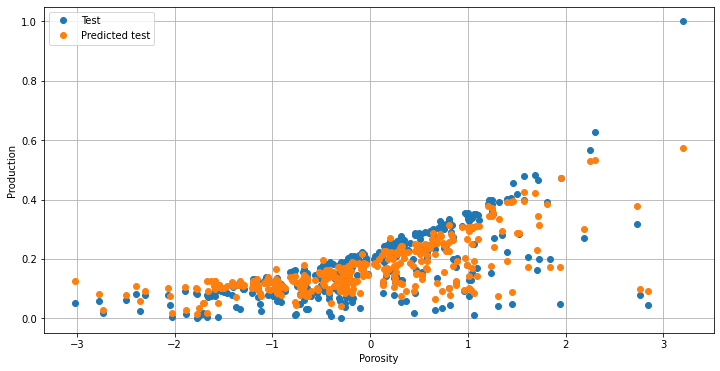

In [32]:
y_test_pred = model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(X_test[:,0],y_test,'o',label='Test')
plt.plot(X_test[:,0],y_test_pred,'o',label='Predicted test')

plt.xlabel('Porosity')
plt.ylabel('Production')
plt.legend()
plt.grid(True)

### Goodness of the uncertainty model

Let's evaluate the goodness of the model.

This is no longer a deterministic approach and we will evaluate the model only 200 times, next we will print the Goodness, Precision and Acurracy of the model.

In [33]:
mc_predictions = evaluate_cases(model, X_test, 8, y_test,200)

42/42 [==============================] - 0s 543us/step


42/42 [==============================] - 0s 608us/step


In [34]:
df = get_dataframe(mc_predictions, y_test, X_test)

How does the cross validation plot look like?
What about the Pearson's product moment correlation coefficient?

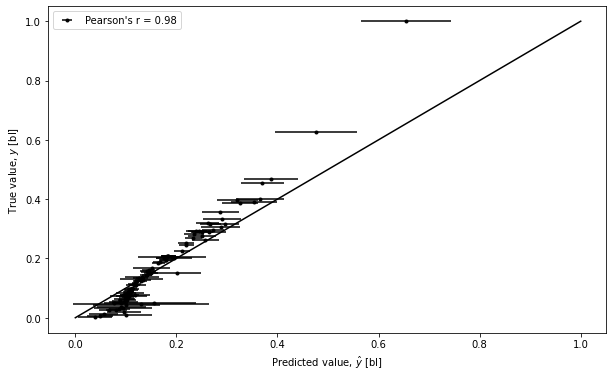

In [35]:
r= stats.pearsonr(df.Pred,df.Truth)
error_line(df.Pred,df.Truth,df.Sigma,r[0])

What is the Goodness, Precision and Accuracy of the model?

In [36]:
Sigma = np.sqrt(np.var(mc_predictions.T, axis=1))

score = scorer(mc_predictions.T, y_test, Sigma)

IF_array = score.IndicatorFunction()
n_quantiles = 11
perc = np.linspace(0.0, 1.00, n_quantiles)


In [37]:
print('Accuracy = {0:2.2f}'.format(score.Accuracy()))
print('Precision = {0:2.2f}'.format(score.Precision()))
print('Goodness = {0:2.2f}'.format(score.Goodness()))

Accuracy = 0.03
Precision = 1.00
Goodness = 0.63


For a random point we can plot the histogram of predictions and estimate the standard deviation of the mean value

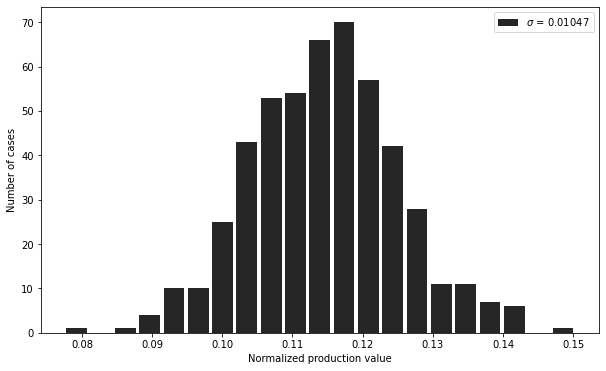

In [38]:
histogram_fixed(mc_predictions,5);

How does the accuracy plot look like for the defined model?

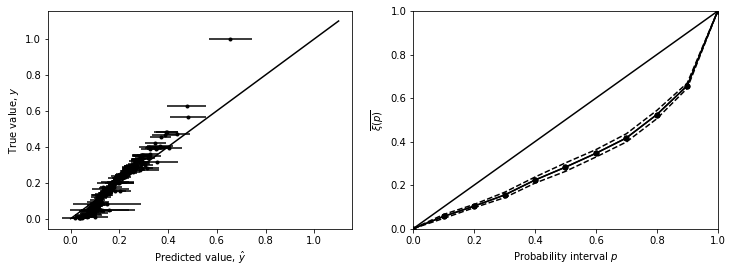

In [39]:
error_accuracy_plot(perc, IF_array, mc_predictions.T, y_test, Sigma)

## Exploration of the hyperparameter space

The model we instantiated in the last section was selected using the following algorithm:

**Input**: m hyperparameter combinations to evaluate
**Output**: optimal dropout with maximum uncertainty model goodness for a given learning rate
1. Use any design of experiments (DOE) to sample m dropout and learning rate values of the search space.
2. Use the objective function defined in equation 8 
3. **while** i<m **do**

    1. Perform model training with specified dropout rate, d; for a given learning rate, lr;
    2. for l=1,…,L ensemble models calculate prediction realizations over the testing data to calculate the nonparametric cumulative distribution function $F_y (u_i)$;
	3. Calculate the average indicator function $\overline{\xi (p)}$ for each discretized symmetric probability interval to calculate the accuracy plot;
	4. Evaluate scores, precision, accuracy, and goodness of the uncertainty model with the proposed objective function;
	5. Evaluate overall uncertainty to split ties for models with similar scores from the proposed objective function
4. **return** optimum dropout with uncertainty model accuracy, precision and the least overall uncertainty.


We use Optuna for hyperparameter tuning and the Uncertainty Model Goodness to search for the optimum value of hyperparameters.

**NOTE**: the following piece of code might be too long to run. So feel free to skip the following lines and just load the results of this grid search  in the next section.

In [ ]:
d_space = np.linspace(0.05, 0.95, 30)
l_space = np.linspace(0.001, .03 , 20)
search_space = {"Dropout": d_space, "learn_rate": l_space}

study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space))

Save our job

In [ ]:
study.optimize(objective,
               n_trials=d_space.shape[0] * l_space.shape[0],
               show_progress_bar=True)

In [ ]:
StudyName='Search-Space'
joblib.dump(study, StudyName+'.pkl')

### Summary of the training

Next we present the summary of the training 

In [40]:
# StudyName='Search-Space'

# study = joblib.load(StudyName+'.pkl')
# df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete'], axis=1)

# df.to_csv('Search-space.csv')

df=pd.read_csv('Search-space.csv')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 600 non-null    int64  
 1   number                     600 non-null    int64  
 2   value                      600 non-null    float64
 3   duration                   600 non-null    object 
 4   params_Dropout             600 non-null    float64
 5   params_learn_rate          600 non-null    float64
 6   system_attrs_grid_id       600 non-null    int64  
 7   system_attrs_search_space  600 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 37.6+ KB


This is how the search space evaluated with the uncertainty model goodness metric looks like:

C:\Users\em42363\AppData\Local\Temp\ipykernel_20168\1542533022.py:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


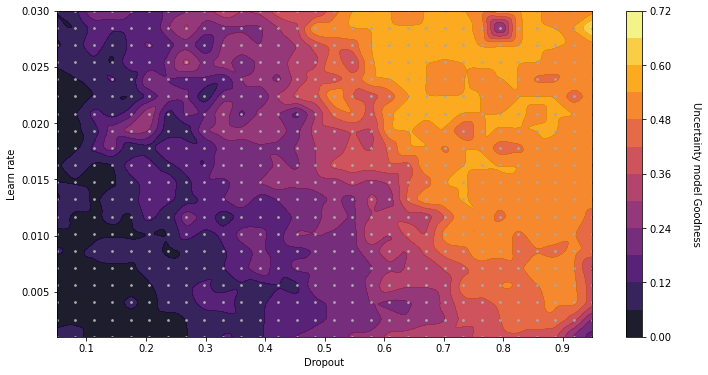

In [42]:
import scipy.ndimage
import matplotlib.tri as tri
from scipy.ndimage.filters import gaussian_filter

z=df['value'].values
x=df['params_Dropout'].values
y=df['params_learn_rate'].values

fig, (ax1) = plt.subplots(nrows=1,figsize=(12,6))

npoints=300
smooth=2

# Create grid values first.
xi = np.linspace(x.min(), x.max(), npoints)
yi = np.linspace(y.min(), y.max(), npoints)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

zi = gaussian_filter(zi, smooth)

levels=10

ax1.contour(xi, yi, zi, levels=levels, linewidths=0.1, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=levels, cmap="inferno",alpha=0.9)

cbar = plt.colorbar(cntr1, ax=ax1)

cbar.set_label('Uncertainty model Goodness', rotation=270,labelpad=30)

ax1.set(xlim=(df.params_Dropout.min(), df.params_Dropout.max()),ylim=(df.params_learn_rate.min(), df.params_learn_rate.max()))
ax1.scatter(x,y,s=3,color='darkgray')
ax1.set_ylabel('Learn rate')
ax1.set_xlabel('Dropout')
plt.show()


## Conclusions and observations

* The work introduces a novel workflow to tune uncertainty models by using the uncertainty model goodness metric.

* This inclusion allows the calculation of robust uncertainty models from machine learning-based ensembles of estimates and robust forecasting.

* This approach is critical to any prediction problem with significant uncertainty.

### Eduardo Maldonado Cruz, Graduate Research Assistant, The University of Texas at Austin

#### [Twitter](https://twitter.com/emaldonadocruz) | [GitHub](https://github.com/emaldonadocruz) | [LinkedIn](https://www.linkedin.com/in/eduardo-maldonado-8386a898/)

### Michael Pyrcz, Associate Professor, The University of Texas at Austin 

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)